<a href="https://colab.research.google.com/github/Olimaol/notebooks-deeprl/blob/main/solutions-output/05-Bandits2.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bandits - part 2

In the exercise, we will investigate in more details the properties of the bandit algorithms implemented last time and investigate more advanced ones (explained in the Sutton and Barto book).

**Q:** Start by copying all class definitions of the last exercise (Bandit, Greedy, $\epsilon$-Greedy, softmax) and re-run the experiments with correct values for the parameters in a single cell. We will ignore exploration scheduling (although we should not).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [2]:
# Solution:
class Bandit:
    """
    n-armed bandit.
    """
    def __init__(self, nb_actions, mean=0.0, std_Q=1.0, std_r=1.0):
        """
        :param nb_actions: number of arms.
        :param mean: mean of the normal distribution for $Q^*$.
        :param std_Q: standard deviation of the normal distribution for $Q^*$.
        :param std_r: standard deviation of the normal distribution for the sampled rewards.
        """
        # Store parameters
        self.nb_actions = nb_actions
        self.mean = mean
        self.std_Q = std_Q
        self.std_r = std_r
        
        # Initialize the true Q-values
        self.Q_star = rng.normal(self.mean, self.std_Q, self.nb_actions)
        
        # Optimal action
        self.a_star = self.Q_star.argmax()
        
    def step(self, action):
        """
        Sampled a single reward from the bandit.
        
        :param action: the selected action.
        :return: a reward.
        """
        return float(rng.normal(self.Q_star[action], self.std_r, 1)[0])

In [3]:
# Solution:
class GreedyAgent:
    def __init__(self, bandit, alpha, Q_init=0.0):
        
        self.bandit = bandit
        self.alpha = alpha
        
        # Estimated Q-values
        self.Q_t = Q_init * np.ones(self.bandit.nb_actions)
        
    def act(self):
        
        action = rng.choice(np.where(self.Q_t == self.Q_t.max())[0])
        return action
        
    def update(self, action, reward):
        
        self.Q_t[action] += self.alpha * (reward - self.Q_t[action])
        
    def train(self, nb_steps):
        
        rewards = []
        optimal = []

        for step in range(1000):

            # Select the action 
            action = self.act()

            # Sample the reward
            reward = self.bandit.step(action)

            # Store the received reward
            rewards.append(reward)
            
            # Optimal action
            if action == self.bandit.a_star:
                optimal.append(1.0)
            else:
                optimal.append(0.0)

            # Update the Q-value estimate of the action
            self.update(action, reward)
            
        return np.array(rewards), np.array(optimal)

In [4]:
# Solution:
class EpsilonGreedyAgent(GreedyAgent):
    
    def __init__(self, bandit, alpha, epsilon, Q_init=0.0):
        
        self.epsilon = epsilon
        
        # List of actions
        self.actions = np.arange(bandit.nb_actions)
        
        # Call the constructor of GreedyAgent
        super().__init__(bandit, alpha, Q_init)
        
    def act(self):
        
        action = rng.choice(np.where(self.Q_t == self.Q_t.max())[0])
        
        if rng.random() < self.epsilon:
            action = rng.choice(self.actions[self.actions != action])
            
        return action

In [5]:
# Solution:
class SoftmaxAgent(GreedyAgent):
    
    def __init__(self, bandit, alpha, tau, Q_init=0.0):
        self.tau = tau
        
        # List of actions
        self.actions = np.arange(bandit.nb_actions)
        
        # Call the constructor of GreedyAgent
        super().__init__(bandit, alpha, Q_init)
        
    def act(self):
        
        logit = np.exp((self.Q_t - self.Q_t.max())/self.tau)
        
        proba_softmax = logit / np.sum(logit)
        
        action = rng.choice(self.actions, p=proba_softmax) 
            
        return action

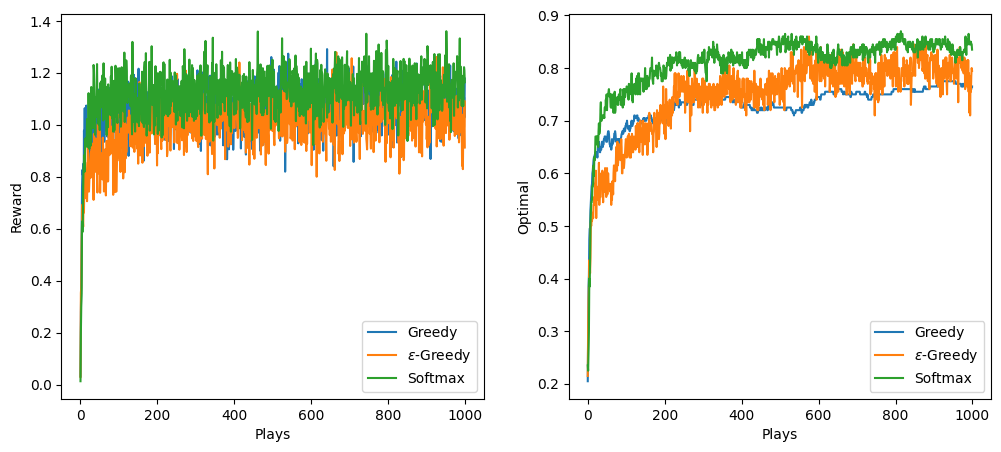

In [6]:
# Solution:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1

# epsilon for exploration
epsilon = 0.1

# Tau for exploration
tau = 0.1

rewards_greedy = []
optimal_greedy = []

rewards_egreedy = []
optimal_egreedy = []

rewards_softmax = []
optimal_softmax = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions)

    # Greedy
    agent = GreedyAgent(bandit, alpha)
    rewards, optimal = agent.train(1000)    
    rewards_greedy.append(rewards)
    optimal_greedy.append(optimal)

    # Greedy
    agent = EpsilonGreedyAgent(bandit, alpha, epsilon)
    rewards, optimal = agent.train(1000)    
    rewards_egreedy.append(rewards)
    optimal_egreedy.append(optimal)

    # Softmax
    agent = SoftmaxAgent(bandit, alpha, tau)
    rewards, optimal = agent.train(1000)    
    rewards_softmax.append(rewards)
    optimal_softmax.append(optimal)
    
rewards_greedy = np.mean(rewards_greedy, axis=0)
optimal_greedy = np.mean(optimal_greedy, axis=0)
rewards_egreedy = np.mean(rewards_egreedy, axis=0)
optimal_egreedy = np.mean(optimal_egreedy, axis=0)
rewards_softmax = np.mean(rewards_softmax, axis=0)
optimal_softmax = np.mean(optimal_softmax, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

## Reward distribution

We are now going to vary the reward distributions and investigate whether the previous experimental results still hold when the true Q-values are in $\mathcal{N}(0, 1)$ and the rewards have a variance of 1.

**Q:** Let's now change the distribution of true Q-values from $\mathcal{N}(0, 1)$ to $\mathcal{N}(10, 10)$ when creating the bandits and re-run the algorithms. What happens and why? Modify the values of `epsilon` and `tau` to try to get a better behavior.

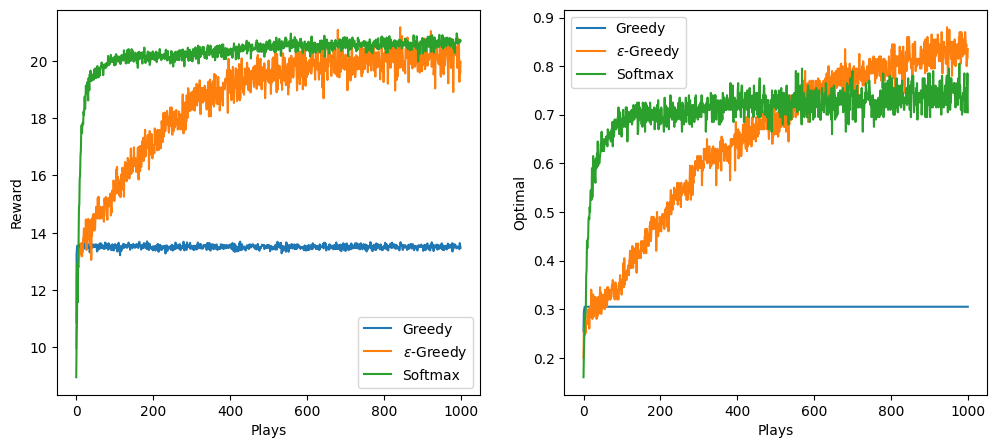

In [7]:
# Solution:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1

# epsilon for exploration
epsilon = 0.1

# Tau for exploration
tau = 3.0

rewards_greedy = []
optimal_greedy = []

rewards_egreedy = []
optimal_egreedy = []

rewards_softmax = []
optimal_softmax = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions, mean=10.0, std_Q=10.0, std_r=1.0)

    # Greedy
    agent = GreedyAgent(bandit, alpha)
    rewards, optimal = agent.train(1000)    
    rewards_greedy.append(rewards)
    optimal_greedy.append(optimal)

    # Greedy
    agent = EpsilonGreedyAgent(bandit, alpha, epsilon)
    rewards, optimal = agent.train(1000)    
    rewards_egreedy.append(rewards)
    optimal_egreedy.append(optimal)

    # Softmax
    agent = SoftmaxAgent(bandit, alpha, tau)
    rewards, optimal = agent.train(1000)    
    rewards_softmax.append(rewards)
    optimal_softmax.append(optimal)
    
rewards_greedy = np.mean(rewards_greedy, axis=0)
optimal_greedy = np.mean(optimal_greedy, axis=0)
rewards_egreedy = np.mean(rewards_egreedy, axis=0)
optimal_egreedy = np.mean(optimal_egreedy, axis=0)
rewards_softmax = np.mean(rewards_softmax, axis=0)
optimal_softmax = np.mean(optimal_softmax, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

**A:** Greedy does not work anymore and stays at chance level. The first action it samples will provide a non-zero reward, so its estimated Q-value becomes positive (initial estimate of 0) and it will keep selecting this non-optimal greedy action all along.

$\epsilon$-greedy still works quite well (although a bit slower as the estimates must go from 0 to 10), even with its default value of 0.1.

Softmax does not work unless you increase the temperature to 3 or so. The correct value of `tau` depends on the scaling of the Q-values, so it has to be adapted to every new problem, contrary to $\epsilon$-greedy. But with the correct value of `tau`, you get a good solution much earlier.

## Optimistic initialization

The initial estimates of 0 are now very **pessimistic** compared to the average reward you can get (between 10 and 20). This was not the case in the original setup.

**Q:** Modify the classes so that they accept a parameter `Q_init` allowing to initialize the estimates `Q_t` to something different from 0. Change the initial value of the estimates to 10 for each algorithm. What happens? Conclude on the importance of reward scaling.

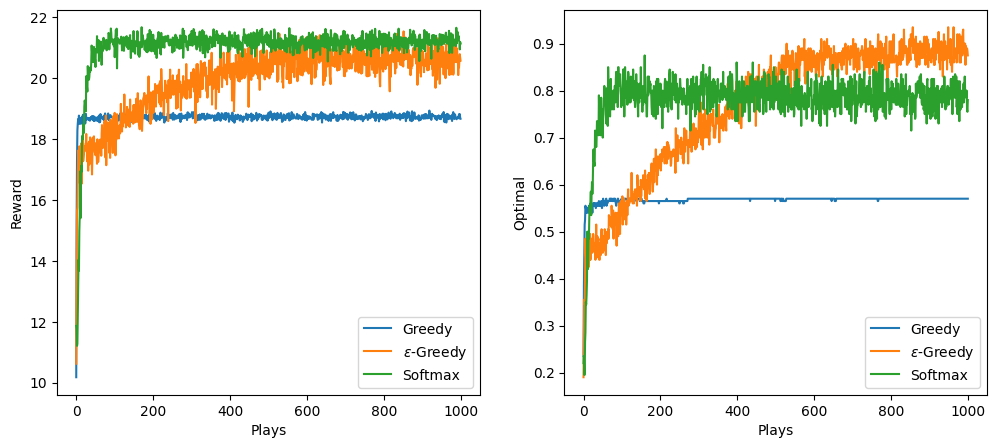

In [8]:
# Solution:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1

# epsilon for exploration
epsilon = 0.1

# Tau for exploration
tau = 3.0

# Optimistic initialization
Q_init = 10.0

rewards_greedy = []
optimal_greedy = []

rewards_egreedy = []
optimal_egreedy = []

rewards_softmax = []
optimal_softmax = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions, mean=10.0, std_Q=10.0, std_r=1.0)

    # Greedy
    agent = GreedyAgent(bandit, alpha, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_greedy.append(rewards)
    optimal_greedy.append(optimal)

    # Greedy
    agent = EpsilonGreedyAgent(bandit, alpha, epsilon, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_egreedy.append(rewards)
    optimal_egreedy.append(optimal)

    # Softmax
    agent = SoftmaxAgent(bandit, alpha, tau, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_softmax.append(rewards)
    optimal_softmax.append(optimal)
    
rewards_greedy = np.mean(rewards_greedy, axis=0)
optimal_greedy = np.mean(optimal_greedy, axis=0)
rewards_egreedy = np.mean(rewards_egreedy, axis=0)
optimal_egreedy = np.mean(optimal_egreedy, axis=0)
rewards_softmax = np.mean(rewards_softmax, axis=0)
optimal_softmax = np.mean(optimal_softmax, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

**A:** Now we are back to quite the same results as before (greedy might still be worse, but not at chance level anymore). This shows the importance of **reward scaling**: the amplitude of the rewards influences a lot the success of the different methods ($\epsilon$-greedy is more robust). This mean you need to know the mean expected reward in advance, but you are not supposed to know that as you have not sampled anything at the beginning...

Let's now use **optimistic initialization**, i.e. initialize the estimates to a much higher value than what is realistic.

**Q:** Implement optimistic initialization by initializing the estimates of all three algorithms to 25. What happens?

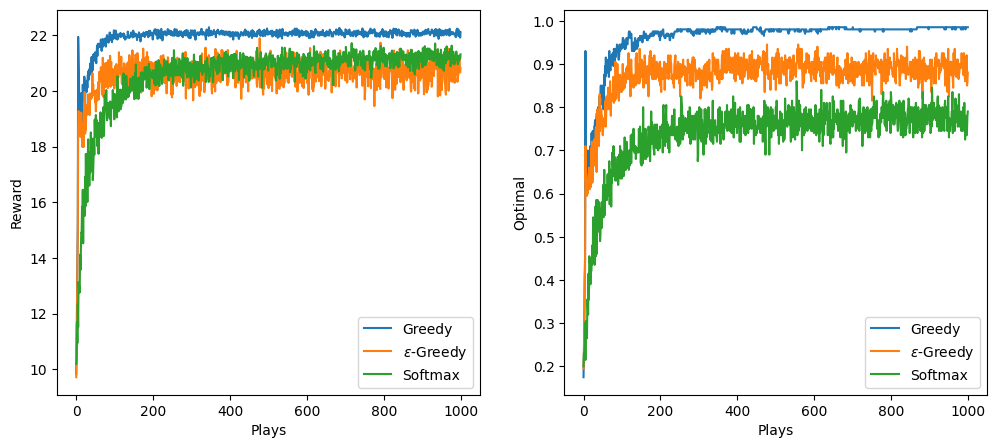

In [9]:
# Solution:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1

# epsilon for exploration
epsilon = 0.1

# Tau for exploration
tau = 3.0

# Optimistic initialization
Q_init = 25.0

rewards_greedy = []
optimal_greedy = []

rewards_egreedy = []
optimal_egreedy = []

rewards_softmax = []
optimal_softmax = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions, mean=10.0, std_Q=10.0, std_r=1.0)

    # Greedy
    agent = GreedyAgent(bandit, alpha, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_greedy.append(rewards)
    optimal_greedy.append(optimal)

    # Greedy
    agent = EpsilonGreedyAgent(bandit, alpha, epsilon, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_egreedy.append(rewards)
    optimal_egreedy.append(optimal)

    # Softmax
    agent = SoftmaxAgent(bandit, alpha, tau, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_softmax.append(rewards)
    optimal_softmax.append(optimal)

rewards_greedy = np.mean(rewards_greedy, axis=0)
optimal_greedy = np.mean(optimal_greedy, axis=0)
rewards_egreedy = np.mean(rewards_egreedy, axis=0)
optimal_egreedy = np.mean(optimal_egreedy, axis=0)
rewards_softmax = np.mean(rewards_softmax, axis=0)
optimal_softmax = np.mean(optimal_softmax, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

**A:** With optimistic initialization, greedy action selection becomes the most efficient method: exploration is ensured by the fact that all actions be be executed at some point, as they can only be disappointing. The received rewards are always lower than the expectation at the beginning, so there is no need for additional exploration mechanisms. But it necessitates to know in advance what the maximal reward is... Note that reducing the exploration parameters help $\epsilon$-greedy and softmax behave like greedy.

## Reinforcement comparison

The problem with the previous **value-based** methods is that the Q-value estimates depend on the absolute magnitude of the rewards (by definition). The hyperparameters of the learning algorithms (learning rate, exploration, initial values) will therefore be very different depending on the scaling of the rewards (between 0 and 1, between -100 and 100, etc).

A way to get rid of this dependency is to introduce **preferences** $p_t(a)$ for each action instead of the estimated Q-values. Preferences should follow the Q-values: an action with a high Q-value should have a high Q-value and vice versa, but we do not care about its exact scaling.

In **reinforcement comparison**, we introduce a baseline $\tilde{r}_t$ which is the average received reward **regardless the action**, i.e. there is a single value for the whole problem. This average reward is simply updated after each action with a moving average of the received rewards:

$$\tilde{r}_{t+1} = \tilde{r}_{t} + \alpha \, (r_t - \tilde{r}_{t})$$

The average reward is used to update the preference for the action that was just executed:

$$p_{t+1}(a_t) = p_{t}(a_t) + \beta \, (r_t - \tilde{r}_{t})$$

If the action lead to more reward than usual, its preference should be increased (good surprise). If the action lead to less reward than usual, its preference should be decreased (bad surprise).

Action selection is simply a softmax over the preferences, without the temperature parameter (as we do not care about the scaling):

$$
    \pi (a) = \frac{\exp p_t(a)}{ \sum_b \exp p_t(b)}
$$ 

**Q:** Implement reinforcement comparison (with $\alpha=\beta=0.1$) and compare it to the other methods on the default settings. 

In [10]:
# Solution:
class ReinforcementComparisonAgent (GreedyAgent):
    
    def __init__(self, bandit, alpha, beta, r_init=0.0):
        
        self.bandit = bandit
        self.alpha = alpha
        self.beta = beta
        
        # List of actions
        self.actions = np.arange(bandit.nb_actions)
        
        # Preferences
        self.p_t = np.zeros(self.bandit.nb_actions)
        
        # Mean reward
        self.r_mean = r_init
        
        
    def act(self):
        
        logit = np.exp((self.p_t - self.p_t.max()))
        
        proba_softmax = logit / np.sum(logit)
        
        action = rng.choice(self.actions, p=proba_softmax) 
            
        return action
        
    def update(self, action, reward):
        
        self.p_t[action] += self.beta * (reward - self.r_mean)
        
        self.r_mean += self.alpha * (reward - self.r_mean)
        

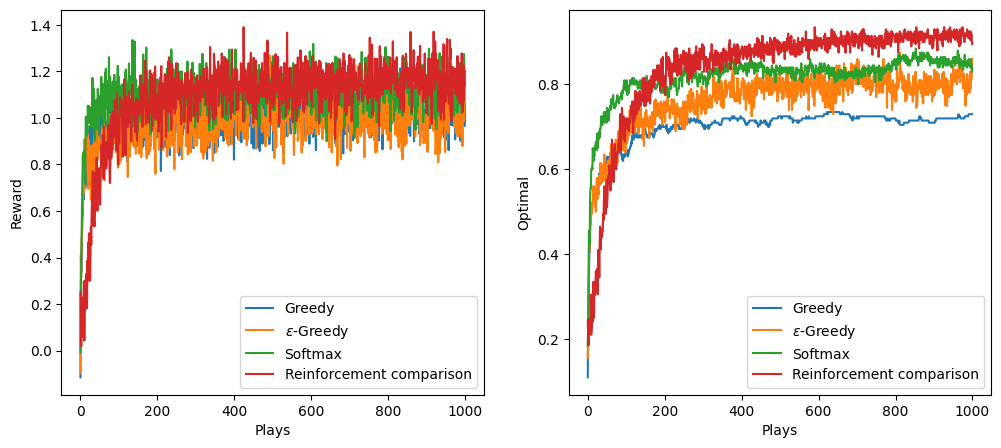

In [11]:
# Solution:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1
beta = 0.1

# epsilon for exploration
epsilon = 0.1

# Tau for exploration
tau = 0.1

rewards_greedy = []
optimal_greedy = []

rewards_egreedy = []
optimal_egreedy = []

rewards_softmax = []
optimal_softmax = []

rewards_rc = []
optimal_rc = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions)

    # Greedy
    agent = GreedyAgent(bandit, alpha)
    rewards, optimal = agent.train(1000)    
    rewards_greedy.append(rewards)
    optimal_greedy.append(optimal)

    # Greedy
    agent = EpsilonGreedyAgent(bandit, alpha, epsilon)
    rewards, optimal = agent.train(1000)    
    rewards_egreedy.append(rewards)
    optimal_egreedy.append(optimal)

    # Softmax
    agent = SoftmaxAgent(bandit, alpha, tau)
    rewards, optimal = agent.train(1000)    
    rewards_softmax.append(rewards)
    optimal_softmax.append(optimal)

    # Reinforcement comparison
    agent = ReinforcementComparisonAgent(bandit, alpha, beta)
    rewards, optimal = agent.train(1000)    
    rewards_rc.append(rewards)
    optimal_rc.append(optimal)
    
rewards_greedy = np.mean(rewards_greedy, axis=0)
optimal_greedy = np.mean(optimal_greedy, axis=0)
rewards_egreedy = np.mean(rewards_egreedy, axis=0)
optimal_egreedy = np.mean(optimal_egreedy, axis=0)
rewards_softmax = np.mean(rewards_softmax, axis=0)
optimal_softmax = np.mean(optimal_softmax, axis=0)
rewards_rc = np.mean(rewards_rc, axis=0)
optimal_rc = np.mean(optimal_rc, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.plot(rewards_rc, label="Reinforcement comparison")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.plot(optimal_rc, label="Reinforcement comparison")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()

**A:** RC is slower at the beginning, but ends up being more optimal. We never estimate the Q-values, but we do not care about them, we only want to perform the correct actions. We also get rid of the temperature parameter.

**Q:** Compare all methods with optimistic initialization. The true Q-values come from $\mathcal{N}(10, 10)$, the estimated Q-values are initialized to 20 for greedy, $\epsilon$-greedy and softmax, and the average reward is initialized to 20 for RC (the preferences are initialized at 0).  

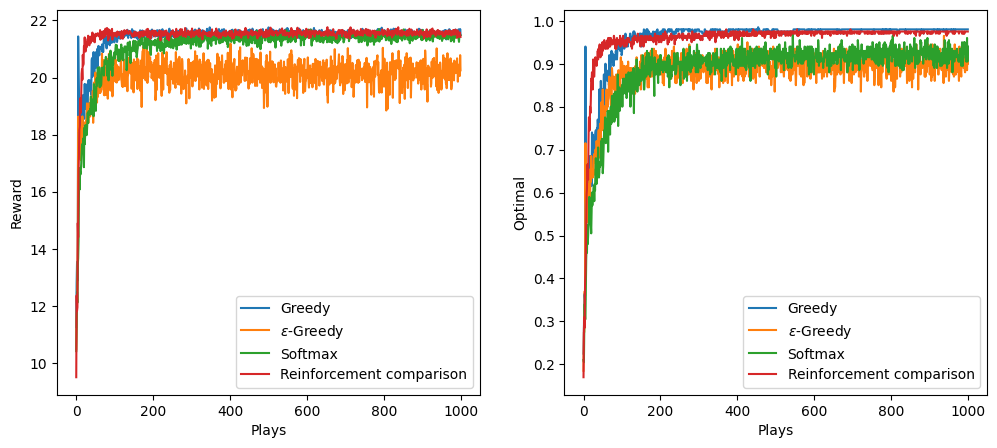

In [12]:
# Solution:
# Number of arms
nb_actions = 5

# Learning rate
alpha = 0.1
beta = 0.1

# epsilon for exploration
epsilon = 0.1

# Tau for exploration
tau = 1.0

# Optimistic initialization
Q_init = 25.0

rewards_greedy = []
optimal_greedy = []

rewards_egreedy = []
optimal_egreedy = []

rewards_softmax = []
optimal_softmax = []

rewards_rc = []
optimal_rc = []

for trial in range(200):

    # Bandit
    bandit = Bandit(nb_actions, mean=10.0, std_Q=10.0, std_r=1.0)

    # Greedy
    agent = GreedyAgent(bandit, alpha, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_greedy.append(rewards)
    optimal_greedy.append(optimal)

    # Greedy
    agent = EpsilonGreedyAgent(bandit, alpha, epsilon, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_egreedy.append(rewards)
    optimal_egreedy.append(optimal)

    # Softmax
    agent = SoftmaxAgent(bandit, alpha, tau, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_softmax.append(rewards)
    optimal_softmax.append(optimal)

    # Reinforcement comparison
    agent = ReinforcementComparisonAgent(bandit, alpha, beta, Q_init)
    rewards, optimal = agent.train(1000)    
    rewards_rc.append(rewards)
    optimal_rc.append(optimal)
    
rewards_greedy = np.mean(rewards_greedy, axis=0)
optimal_greedy = np.mean(optimal_greedy, axis=0)
rewards_egreedy = np.mean(rewards_egreedy, axis=0)
optimal_egreedy = np.mean(optimal_egreedy, axis=0)
rewards_softmax = np.mean(rewards_softmax, axis=0)
optimal_softmax = np.mean(optimal_softmax, axis=0)
rewards_rc = np.mean(rewards_rc, axis=0)
optimal_rc = np.mean(optimal_rc, axis=0)
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(rewards_greedy, label="Greedy")
plt.plot(rewards_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(rewards_softmax, label="Softmax")
plt.plot(rewards_rc, label="Reinforcement comparison")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.subplot(122)
plt.plot(optimal_greedy, label="Greedy")
plt.plot(optimal_egreedy, label=r"$\epsilon$-Greedy")
plt.plot(optimal_softmax, label="Softmax")
plt.plot(optimal_rc, label="Reinforcement comparison")
plt.legend()
plt.xlabel("Plays")
plt.ylabel("Optimal")
plt.show()